In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn import preprocessing

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

from lofo import LOFOImportance, Dataset, plot_importance
from iterstrat.ml_stratifiers import (
    RepeatedMultilabelStratifiedKFold,
    MultilabelStratifiedShuffleSplit
)
from sklearn.metrics import make_scorer

pd.set_option('display.max_columns', None)

import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

Id        AB          AF          AH          AM         AR  \
0    000ff2bfdfe9  0.209377  3109.03329   85.200147   22.394407   8.138688   
1    007255e47698  0.145282   978.76416   85.200147   36.968889   8.138688   
2    013f2bd269f5  0.470030  2635.10654   85.200147   32.360553   8.138688   
3    043ac50845d5  0.252107  3819.65177  120.201618   77.112203   8.138688   
4    044fb8a146ec  0.380297  3733.04844   85.200147   14.103738   8.138688   
..            ...       ...         ...         ...         ...        ...   
612  fd3dafe738fd  0.149555  3130.05946  123.763599    9.513984  13.020852   
613  fd895603f071  0.435846  5462.03438   85.200147   46.551007  15.973224   
614  fd8ef6377f76  0.427300  2459.10720  130.138587   55.355778  10.005552   
615  fe1942975e40  0.363205  1263.53524   85.200147   23.685856   8.138688   
616  ffcca4ded3bb  0.482849  2672.53426  546.663930  112.006102   8.138688   

           AX        AY         AZ          BC          BD       BN  \
0    0.699861  0.025578   9.812214    5.555634  4126.58731  22.5984   
1    3.632190  0.025578  13.517790    1.229900  5496.92824  19.4205   
2    6.732840  0.025578  12.824570    1.229900  5135.78024  26.4825   
3    3.685344  0.025578  11.053708    1.229900  4169.67738  23.6577   
4    3.942255  0.054810   3.396778  102.151980  5728.73412  24.0108   
..        ...       ...        ...         ...         ...      ...   
612  3.499305  0.077343   8.545512    2.804172  4157.68439  21.1860   
613  5.979825  0.025882  12.622906    3.777550  5654.07556  27.1887   
614  8.070549  0.025578  15.408390    1.229900  5888.87769  20.4798   
615  7.981959  0.025578   7.524588    1.229900  4517.86560  19.0674   
616  3.198099  0.116928   3.396778    7.948668  2818.01707  21.1860   

             BP          BQ           BR          BZ         CB        CC  \
0    175.638726  152.707705   823.928241  257.432377  47.223358  0.563481   
1    155.868030   14.754720    51.216883  257.432377  30.284345  0.484710   
2    128.988531  219.320160   482.141594  257.432377  32.563713  0.495852   
3    237.282264   11.050410   661.518640  257.432377  15.201914  0.717882   
4    324.546318  149.717165  6074.859475  257.432377  82.213495  0.536467   
..          ...         ...          ...         ...        ...       ...   
612  167.877117   27.287375   365.516874  257.432377  41.368691  0.691257   
613  285.628059  344.644105   505.006814  257.432377  61.910576  0.772304   
614  178.661133  103.988995  2083.880500  257.432377  90.411867  0.708616   
615  119.162529         NaN   722.377629  257.432377  12.499760  0.602254   
616  306.127863    6.090490   747.474930  257.432377  67.222974  0.644837   

             CD         CF        CH        CL        CR         CS        CU  \
0     23.387600   4.851915  0.023482  1.050225  0.069225  13.784111  1.302012   
1     50.628208   6.085041  0.031442  1.113875  1.117800  28.310953  1.357182   
2     85.955376   5.376488  0.036218  1.050225  0.700350  39.364743  1.009611   
3     88.159360   2.347652  0.029054  1.400300  0.636075  41.116960  0.722727   
4     72.644264  30.537722  0.025472  1.050225  0.693150  31.724726  0.827550   
..          ...        ...       ...       ...       ...        ...       ...   
612   55.163024   4.780452  0.013930  1.177525  0.698250  40.159779  1.070298   
613   85.233928   6.682597  0.038208  1.050225  0.761025  39.852923  2.146113   
614  142.680216   7.809288  0.027462  1.495775  0.879825  39.364743  1.489590   
615  122.939496   2.964975  0.022288  1.050225  0.583125  34.367872  1.428903   
616  271.240664  10.479286  0.076018  1.241175  2.404275  42.799438  0.915822   

            CW         DA          DE        DF        DH          DI  \
0    36.205956   69.08340  295.570575  0.238680  0.284232   89.245560   
1    37.476568   70.79836  178.553100  0.238680  0.363489  110.581815   
2    21.459644   70.81970  321.426625  0.238680  0.210441  120.056438   
3    21.530392   47.27586  196.6079

***
## correlation between features

In [3]:
cols_pearson = train[input_cols].corr(method="pearson")
cols_spearman = train[input_cols].corr(method="spearman")

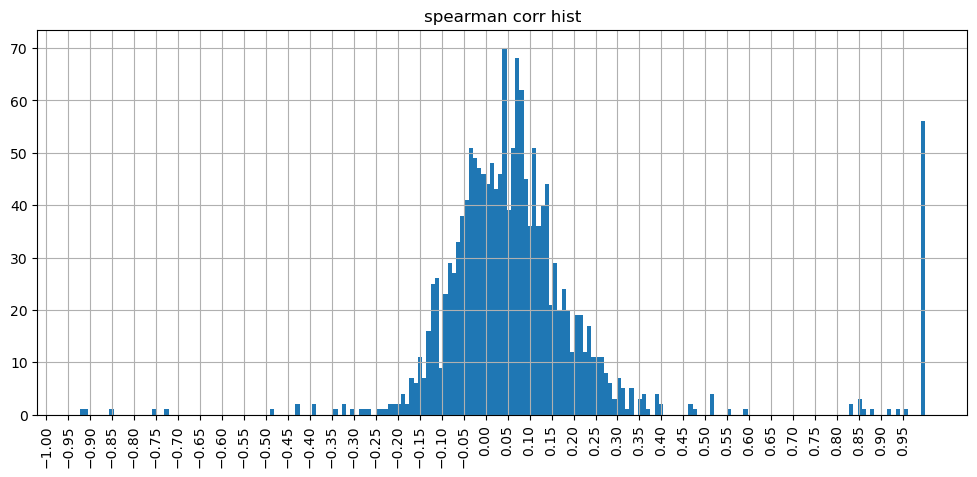

In [4]:
corrs = cols_spearman.values
corrs = corrs[np.triu_indices(corrs.shape[0])]

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(corrs, bins=200)
plt.grid()
x_ticks = np.arange(-1, 1, 0.05)
ax.set_xticks(x_ticks)
plt.xticks(rotation = 90)
plt.title("spearman corr hist")
plt.show()

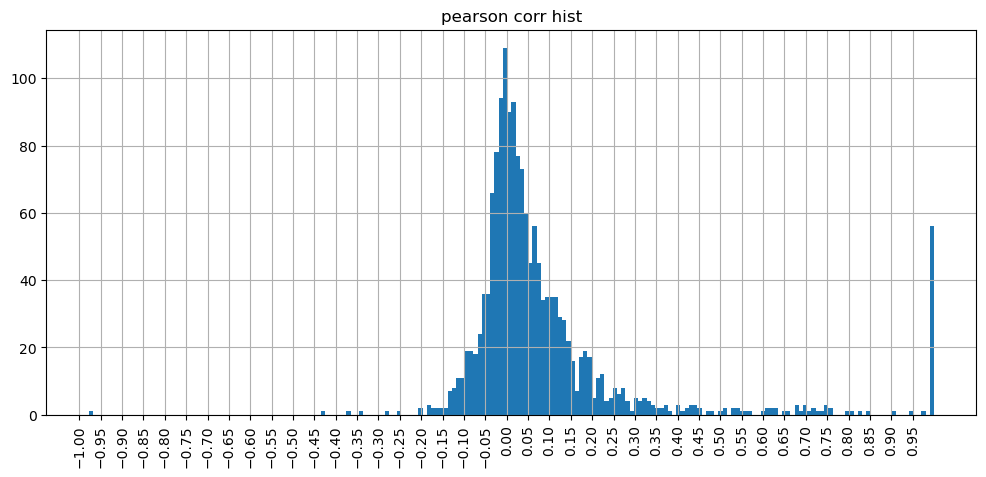

In [5]:
corrs = cols_pearson.values
corrs = corrs[np.triu_indices(corrs.shape[0])]

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(corrs, bins=200)
plt.grid()
x_ticks = np.arange(-1, 1, 0.05)
ax.set_xticks(x_ticks)
plt.xticks(rotation = 90)
plt.title("pearson corr hist")
plt.show()

***
## training

In [6]:
def balanced_logloss_(y_true, y_pred):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, 1e-15, 1-1e-15)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / n0
    log_loss1 = - np.sum(y_true * np.log(p1)) / n1
    return (log_loss0 + log_loss1)/2

def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'balanced_logloss', balanced_logloss_(y_true, y_pred), False 

balanced_logloss_scorer = make_scorer(
    balanced_logloss_, 
    greater_is_better=False
)

In [7]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [8]:
#balance_method = "weight"
balance_method = "bagging"

model_params = {
    'objective': 'binary',
    'metric': 'None',
    'learning_rate': 0.005,
    'max_bin': 63,
    'num_leaves': 7,
    'seed': 2112,
    'first_metric_only': False,
    'feature_pre_filter': False,
    'verbosity': -1,
    'feature_fraction': 0.75,
    'lambda_l1': 0.00020196676966216634,
    'lambda_l2': 2.3627262174517976e-09,
    'min_data_in_leaf': 13,
    'min_gain_to_split': 0.0007626326850799573,
    'num_iterations': 1591,
    'path_smooth': 2.652521741711401e-09
}

if balance_method == "weight":
    model_params["scale_pos_weight"] = scale_pos_weight
elif balance_method == "bagging":
    model_params["bagging_freq"] = 1
    model_params["pos_bagging_fraction"] = 1
    model_params["neg_bagging_fraction"] = neg_bagging_fraction
else:
    print("Unknown balance_method")
    
display(model_params)

{'objective': 'binary',
 'metric': 'None',
 'learning_rate': 0.005,
 'max_bin': 63,
 'num_leaves': 7,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'feature_fraction': 0.75,
 'lambda_l1': 0.00020196676966216634,
 'lambda_l2': 2.3627262174517976e-09,
 'min_data_in_leaf': 13,
 'min_gain_to_split': 0.0007626326850799573,
 'num_iterations': 1591,
 'path_smooth': 2.652521741711401e-09,
 'bagging_freq': 1,
 'pos_bagging_fraction': 1,
 'neg_bagging_fraction': 0.21218074656188604}

In [9]:
# base model
lgbm_model = LGBMClassifier(**model_params)
display(lgbm_model)

LGBMClassifier(bagging_freq=1, feature_fraction=0.75, feature_pre_filter=False,
               first_metric_only=False, lambda_l1=0.00020196676966216634,
               lambda_l2=2.3627262174517976e-09, learning_rate=0.005,
               max_bin=63, metric='None', min_data_in_leaf=13,
               min_gain_to_split=0.0007626326850799573,
               neg_bagging_fraction=0.21218074656188604, num_iterations=1591,
               num_leaves=7, objective='binary',
               path_smooth=2.652521741711401e-09, pos_bagging_fraction=1,
               seed=2112, verbosity=-1)

In [10]:
# input dataset
dset = Dataset(
    df = train,
    target = "Class",
    features = input_cols,
    auto_group_threshold = 0.5,
)

Automatically grouped features by correlation:
1 ['AB', 'AM', 'CH']
2 ['AR', 'DI', 'GI']
3 ['AY', 'EP']
4 ['CU', 'DH']
5 ['DU', 'EH', 'EJ', 'FD', 'FL', 'GL']


In [11]:
# cv-split
#rmskf = RepeatedMultilabelStratifiedKFold(n_splits=5, n_repeats=20, random_state=2112)
#rmskf_split = list(rmskf.split(train, train[["Class","Alpha_B","Alpha_D","Alpha_G"]]))

msss = MultilabelStratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=2112)
msss_split = list(msss.split(train, train[["Class","Alpha_B","Alpha_D","Alpha_G"]]))

In [12]:
lofo_imp = LOFOImportance(
    dataset = dset,
    scoring = balanced_logloss_scorer,
    model = lgbm_model,
    fit_params = None,
    cv = msss_split,
    n_jobs = 1,
    
)

In [13]:
%%time
importance_df = lofo_imp.get_importance()

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

  0%|                                                                                                                                                      | 0/45 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

  2%|███▏                                                                                                                                          | 1/45 [01:13<53:34, 73.05s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

  4%|██████▎                                                                                                                                       | 2/45 [02:26<52:39, 73.48s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

  7%|█████████▍                                                                                                                                    | 3/45 [03:40<51:30, 73.58s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

  9%|████████████▌                                                                                                                                 | 4/45 [04:54<50:15, 73.54s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 11%|███████████████▊                                                                                                                              | 5/45 [06:06<48:52, 73.32s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 13%|██████████████████▉                                                                                                                           | 6/45 [07:20<47:42, 73.39s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 16%|██████████████████████                                                                                                                        | 7/45 [08:33<46:20, 73.18s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 18%|█████████████████████████▏                                                                                                                    | 8/45 [09:44<44:45, 72.58s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 20%|████████████████████████████▍                                                                                                                 | 9/45 [10:56<43:20, 72.24s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 22%|███████████████████████████████▎                                                                                                             | 10/45 [12:07<42:02, 72.08s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 24%|██████████████████████████████████▍                                                                                                          | 11/45 [13:19<40:43, 71.86s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 27%|█████████████████████████████████████▌                                                                                                       | 12/45 [14:30<39:23, 71.62s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 29%|████████████████████████████████████████▋                                                                                                    | 13/45 [15:41<38:09, 71.55s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 31%|███████████████████████████████████████████▊                                                                                                 | 14/45 [16:52<36:56, 71.52s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 33%|███████████████████████████████████████████████                                                                                              | 15/45 [18:04<35:44, 71.49s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 36%|██████████████████████████████████████████████████▏                                                                                          | 16/45 [19:16<34:38, 71.67s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 38%|█████████████████████████████████████████████████████▎                                                                                       | 17/45 [20:27<33:22, 71.53s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 40%|████████████████████████████████████████████████████████▍                                                                                    | 18/45 [21:39<32:10, 71.50s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 42%|███████████████████████████████████████████████████████████▌                                                                                 | 19/45 [22:51<31:05, 71.75s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 44%|██████████████████████████████████████████████████████████████▋                                                                              | 20/45 [24:02<29:50, 71.62s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 47%|█████████████████████████████████████████████████████████████████▊                                                                           | 21/45 [25:14<28:37, 71.56s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 49%|████████████████████████████████████████████████████████████████████▉                                                                        | 22/45 [26:25<27:27, 71.61s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 51%|████████████████████████████████████████████████████████████████████████                                                                     | 23/45 [27:37<26:14, 71.59s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 53%|███████████████████████████████████████████████████████████████████████████▏                                                                 | 24/45 [28:48<25:02, 71.53s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 25/45 [30:00<23:53, 71.66s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 58%|█████████████████████████████████████████████████████████████████████████████████▍                                                           | 26/45 [31:12<22:39, 71.55s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 27/45 [32:23<21:27, 71.55s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 62%|███████████████████████████████████████████████████████████████████████████████████████▋                                                     | 28/45 [33:35<20:18, 71.65s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 64%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 29/45 [34:47<19:06, 71.63s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 30/45 [35:58<17:53, 71.56s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 31/45 [37:09<16:40, 71.50s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 32/45 [38:21<15:28, 71.40s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 33/45 [39:32<14:16, 71.34s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 34/45 [40:44<13:09, 71.73s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 35/45 [41:56<11:56, 71.70s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 36/45 [43:08<10:46, 71.83s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 37/45 [44:21<09:36, 72.10s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 38/45 [45:33<08:24, 72.02s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 39/45 [46:45<07:12, 72.02s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 40/45 [47:56<05:59, 71.93s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 41/45 [49:10<04:49, 72.34s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 42/45 [50:21<03:35, 71.89s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 43/45 [51:33<02:23, 71.91s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 44/45 [52:44<01:11, 71.82s/it]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.3627262174517976e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3627262174517976e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0007626326850799573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007626326850799573
[LightGBM] [Warning] lambda_l1 is set=0.00020196676966216634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020196676966216634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Curr

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [53:54<00:00, 71.88s/it]

CPU times: user 7h 6min 9s, sys: 6min 16s, total: 7h 12min 26s
Wall time: 55min 7s



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/lofo/utils.py:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/lofo/utils.py:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/lofo/utils.py:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conc

In [14]:
importance_df

feature  importance_mean  importance_std  val_imp_0  \
44  DU & EH & EJ & FD & FL & GL         3.078477        1.586135   1.569944   
18                           FR         0.187009        0.525648  -0.169312   
31                           BQ         0.154687        0.836938   1.400633   
43                      CU & DH         0.126057        0.501270  -0.169312   
40                 AB & AM & CH         0.124211        0.711231  -0.169312   
38                           FI         0.102355        0.488006   0.000000   
27                           DL         0.094351        0.582816   0.000000   
41                 AR & DI & GI         0.089733        0.478356   0.784972   
36                           EU         0.080806        0.494546  -0.169312   
42                      AY & EP         0.075727        0.479660  -0.169312   
16                           BP         0.066645        0.415985  -0.169312   
13                           BN         0.065723        0.430476  -0.169312   
19                           CR         0.060952        0.541703   0.446349   
7                            AX         0.059412        0.434306  -0.169312   
24                           CW         0.055564        0.423893   0.000000   
5                            CL         0.055564        0.390359  -0.169312   
22                           CF         0.053871        0.410409  -0.169312   
6                            BZ         0.038171        0.404250  -0.169312   
15                           DY         0.036171        0.572492  -0.954284   
35                           EB         0.034478        0.440514   0.000000   
37                           GB         0.029244        0.428897   0.000000   
30                           FS         0.028629        0.399614   0.784972   
14                           CD         0.025242        0.495996  -0.169312   
8                            CS         0.022011        0.410938   0.000000   
3                            DA         0.019702        0.517224   0.000000   
23                           AH         0.019702        0.362074   0.000000   
0                            BC         0.016161        0.527928  -0.169312   
39                           DV         0.009081        0.380520   0.000000   
33                           BD         0.004002        0.358395   0.000000   
17                           GH         0.002925        0.369770   0.000000   
4                            AF        -0.006157        0.632901   0.615661   
12                           GE        -0.006157        0.474682  -0.169312   
29                           AZ        -0.012929        0.385441   0.000000   
21                           EE        -0.017393        0.593833  -0.169312   
20                           FE        -0.019086        0.402309  -0.169312   
9                            EG        -0.019086        0.423665  -0.169312   
28                           FC        -0.021240        0.386307   0.000000   
11                           BR        -0.022933        0.334828  -0.169312   
26                           GF        -0.024626        0.422236   0.000000   
1                            DF        -0.026320        0.342389   0.000000   
2                            DN        -0.031553        0.390490  -0.338623   
32                           EL        -0.039094        0.597701  -0.169312   
25                           DE        -0.042635        0.518458   0.000000   
10                           CB        -0.044173        0.449740  -0.169312   
34                           CC        -0.065414        0.648956   0.000000   

    val_imp_1  val_imp_2  val_imp_3  val_imp_4  val_imp_5  val_imp_6  \
44   3.924861   1.739256   3.924861   3.032163   2.970577   3.924861   
18   0.000000   0.000000   0.169312   0.000000   0.000000  -0.169312   
31   0.169312  -0.615661   1.569944  -0.784972   0.338623  -0.169312   
43   0.000000   0.000000   0.784972   0.000000  -0.784972   0.784972   
40   0.000000   0.000000   1.

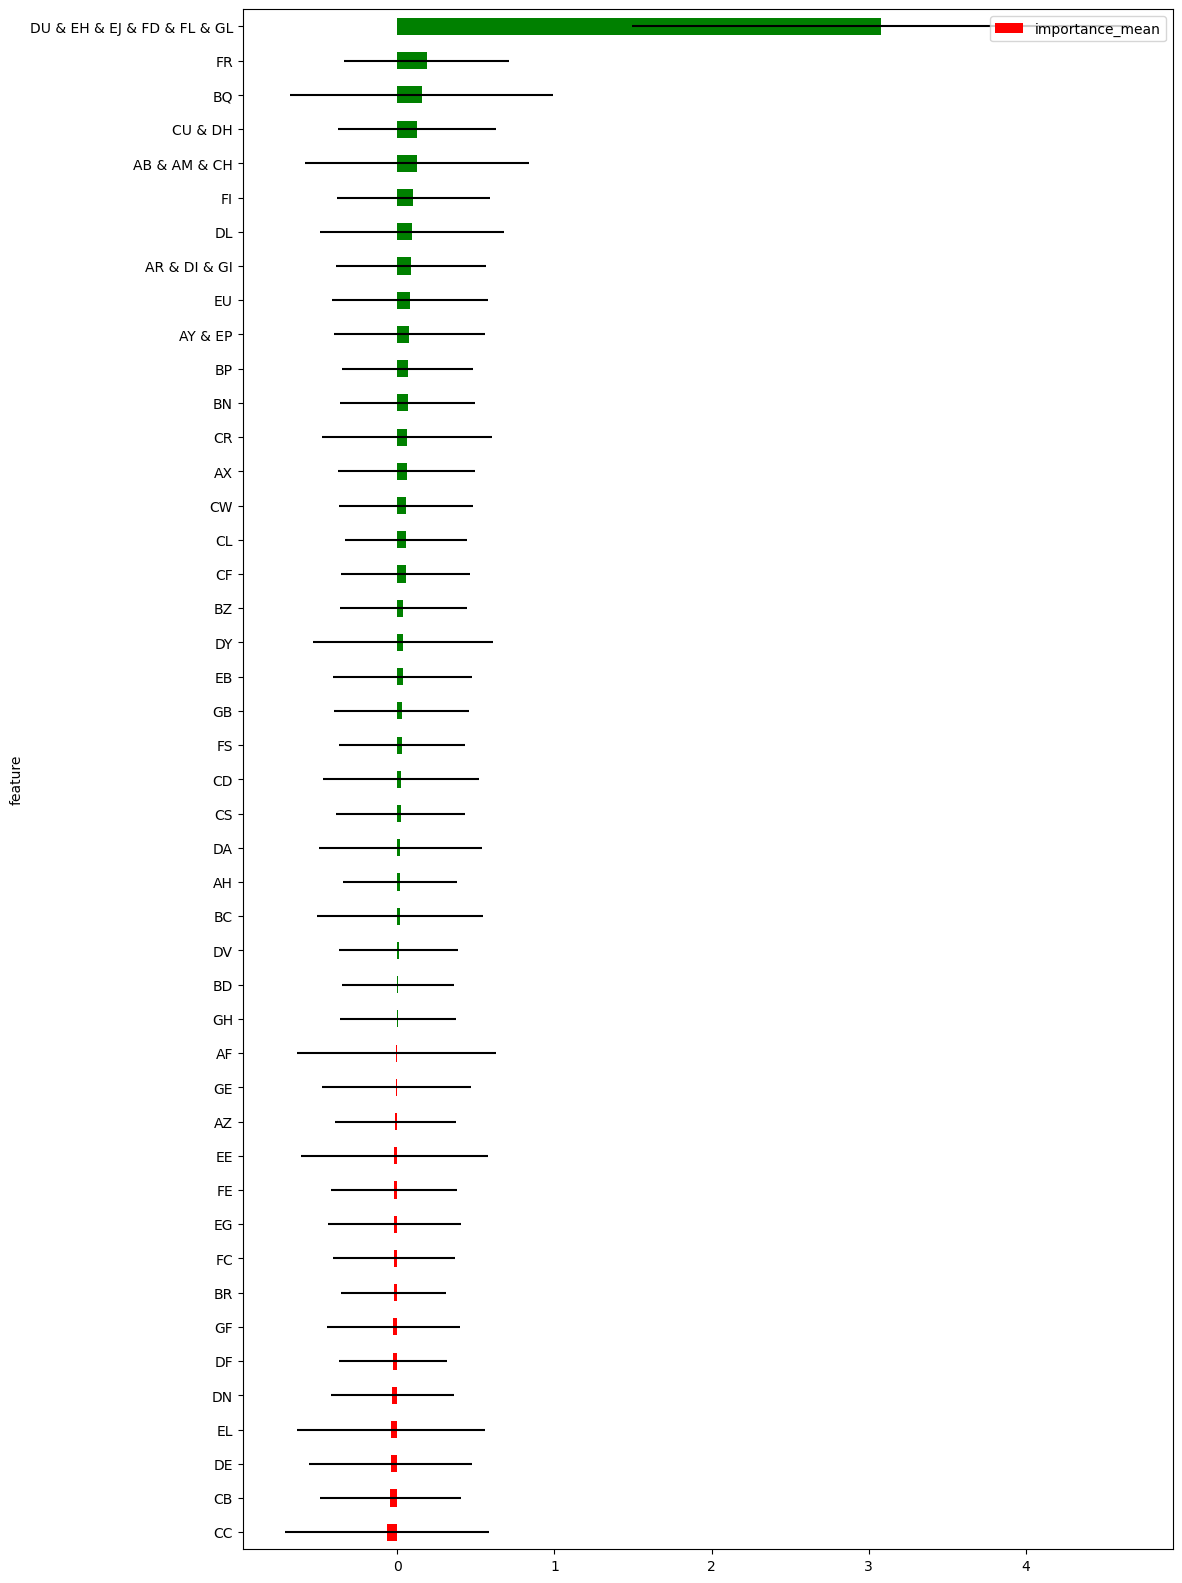

In [15]:
# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(12, 20))

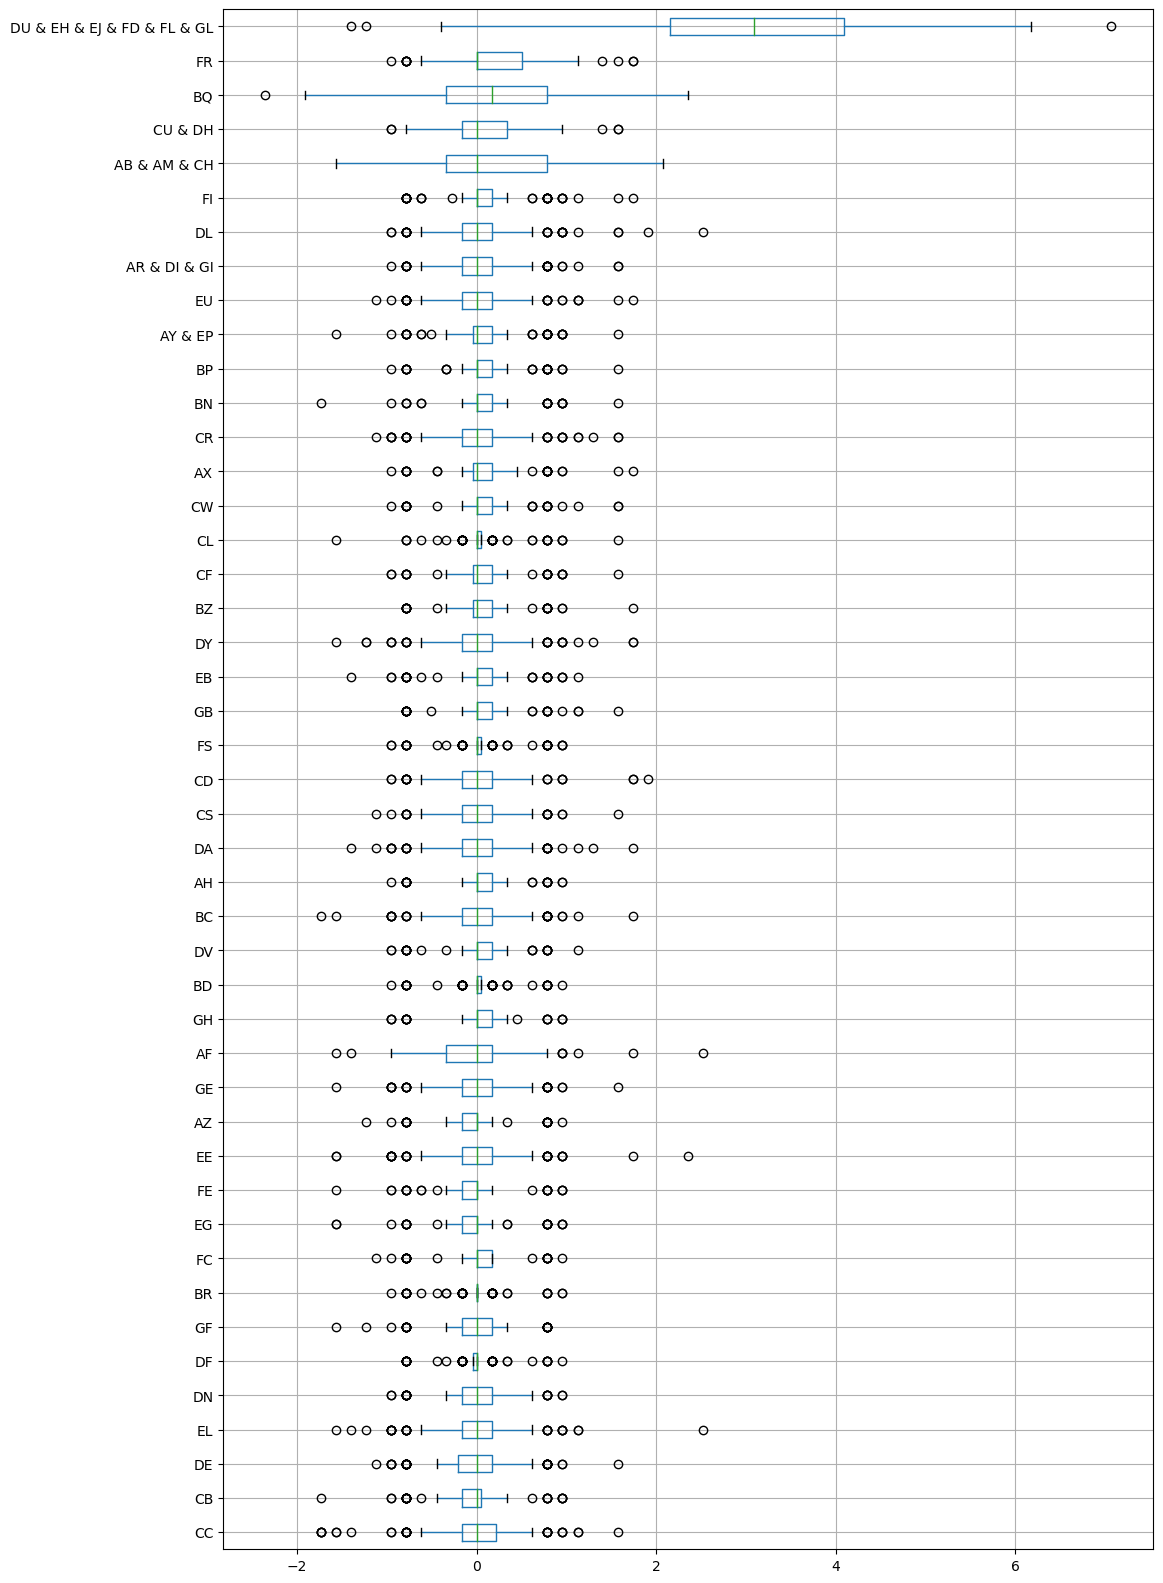

In [16]:
# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(12, 20), kind="box")

In [17]:
importance_df.query("importance_mean < - 0.01").feature.values.tolist()

['AZ', 'EE', 'FE', 'EG', 'FC', 'BR', 'GF', 'DF', 'DN', 'EL', 'DE', 'CB', 'CC']

***